In [1]:
# THIS SCRIPT IS TO GENERATE AGGREGATIONS OF EXPLANATIONS for interesting FINDINGS

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision import transforms

import torch
import torchvision

torch.set_num_threads(1)
torch.manual_seed(0)
np.random.seed(0)

from torchvision.models import *
from visualisation.core.utils import device, image_net_postprocessing
from torch import nn
from operator import itemgetter
from visualisation.core.utils import imshow
from IPython.core.debugger import Tracer

NN_flag = True

In [4]:
layer = 4
if NN_flag:
    feature_extractor = nn.Sequential(*list(resnet34(pretrained=True).children())[:layer-6]).to(device)
    
model = resnet34(pretrained=True).to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# %matplotlib notebook 
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch 
from utils import *
from PIL import Image

plt.rcParams["figure.figsize"]= 16,8


def make_dir(path):
    if os.path.isdir(path) == False:
        os.mkdir(path)

In [6]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow

from visualisation.core.utils import device 
from PIL import Image
from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from visualisation.core import *
from visualisation.core.utils import image_net_preprocessing

size = 224

# Pre-process the image and convert into a tensor
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
])

img_num = 50

# methods = ['Conf', 'GradCAM', 'EP', 'SHAP', 'NNs', 'PoolNet', 'AIonly']
methods = ['Conf', 'GradCAM', 'EP', 'NNs', 'PoolNet', 'AIonly']

task = 'Natural'
# Adversarial_Nat

In [10]:
# Added for loading ImageNet classes
def load_imagenet_label_map():
    """
    Load ImageNet label dictionary.
    return:
    """

    input_f = open("input_txt_files/imagenet_classes.txt")
    label_map = {}
    for line in input_f:
        parts = line.strip().split(": ")
        (num, label) = (int(parts[0]), parts[1].replace('"', ""))
        label_map[num] = label

    input_f.close()
    return label_map


# Added for loading ImageNet classes
def load_imagenet_id_map():
    """
    Load ImageNet ID dictionary.
    return;
    """

    input_f = open("input_txt_files/synset_words.txt")
    label_map = {}
    for line in input_f:
        parts = line.strip().split(" ")
        (num, label) = (parts[0], ' '.join(parts[1:]))
        label_map[num] = label

    input_f.close()
    return label_map

def convert_imagenet_label_to_id(label_map, key_list, val_list, prediction_class):
    """
    Convert imagenet label to ID: for example - 245 -> "French bulldog" -> n02108915
    :param label_map:
    :param key_list:
    :param val_list:
    :param prediction_class:
    :return:
    """
    class_to_label = label_map[prediction_class]
    prediction_id = key_list[val_list.index(class_to_label)]
    return prediction_id


# gt_dict = load_imagenet_validation_gt()
id_map = load_imagenet_id_map()
label_map = load_imagenet_label_map()

key_list = list(id_map.keys())
val_list = list(id_map.values())

def convert_imagenet_id_to_label(label_map, key_list, val_list, class_id):
    """
    Convert imagenet label to ID: for example - n02108915 -> "French bulldog" -> 245
    :param label_map:
    :param key_list:
    :param val_list:
    :param prediction_class:
    :return:
    """
    return key_list.index(str(class_id))

from torchray.attribution.extremal_perturbation import extremal_perturbation, contrastive_reward
from torchray.attribution.grad_cam import grad_cam
import PIL.Image

def get_EP_saliency_maps(model, path):
        img_index = (path.split('.jpeg')[0]).split('images/')[1]
        img = PIL.Image.open(path)
        x = transform(img).unsqueeze(0).to(device)
        out = model(x)
        p = torch.nn.functional.softmax(out, dim=1)
        score, index = torch.topk(p, 1)
        category_id_1 = index[0][0].item()
        
        gt_label_id = img_index.split('val_')[1][9:18]
        input_prediction_id = convert_imagenet_label_to_id(label_map, key_list, val_list, category_id_1)

        masks, energy = extremal_perturbation(
            model, x, category_id_1,
            areas=[0.025, 0.05, 0.1, 0.2],
            num_levels=8,
            step=7,
            sigma=7 * 3,
            max_iter=800,
            debug=False,
            jitter=True,
            smooth=0.09,
            perturbation='blur'
        )
        saliency = masks.sum(dim=0, keepdim=True)
        saliency = saliency.detach()

        return saliency[0].to('cpu')

In [11]:
# import os
import os.path
from visualisation.core.utils import tensor2cam
postprocessing_t = image_net_postprocessing
import cv2 as cv
import sys

imagenet_train_path = '/home/dexter/Downloads/train'

## Creating colormap
cMap = 'Reds'

id_list= list()
conf_dict = {}
eps=1e-5
cnt = 0
K = 3 # Change to your expected number of nearest neighbors

In [13]:
import csv
reader = csv.reader(open('csv_files/definition.csv'))
definition_dict = dict()
for row in reader:
    key = row[0][:9]
    definition = row[0][12:]
    definition_dict[key] = definition
# Added for loading ImageNet classes
def load_imagenet_id_map():
    """
    Load ImageNet ID dictionary.
    return;
    """

    input_f = open("input_txt_files/synset_words.txt")
    label_map = {}
    for line in input_f:
        parts = line.strip().split(" ")
        (num, label) = (parts[0], ' '.join(parts[1:]))
        label_map[num] = label

    input_f.close()
    return label_map
id_map = load_imagenet_id_map()

In [14]:
Q1_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/Finding_explanations/SOD_wrong_dogs_aggregate'
Q2_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/Finding_explanations/NNs_hard_imagenet_aggregate'
Q3_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/Finding_explanations/NNs_adversarial_imagenet_aggregate'
Q4_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/Finding_explanations/Conf_adversarial_dog_aggregate'
Q5_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/Finding_explanations/GradCAM_norm_imagenet_aggregate'
Q6_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/Finding_explanations/NNs_easy_imagenet_aggregate'
Q_datapath = ['/home/dexter/Downloads/Human_experiments/Dataset/Dog/mixed_images',
             '/home/dexter/Downloads/Human_experiments/Dataset/Natural/mixed_images',
             '/home/dexter/Downloads/Human_experiments/Dataset/Adversarial_Nat/mixed_images',
             '/home/dexter/Downloads/Human_experiments/Dataset/Adversarial_Dog/mixed_images',
             '/home/dexter/Downloads/Human_experiments/Dataset/Natural/mixed_images',
             '/home/dexter/Downloads/Human_experiments/Dataset/Natural/mixed_images']

caldron
0.30
Before...
{'/home/dexter/Downloads/train/n02939185/n02939185_54592.JPEG': tensor(255.8752, device='cuda:0'), '/home/dexter/Downloads/train/n02939185/n02939185_3473.JPEG': tensor(259.4665, device='cuda:0'), '/home/dexter/Downloads/train/n02939185/n02939185_6902.JPEG': tensor(259.8627, device='cuda:0')}
After...
{'/home/dexter/Downloads/train/n02939185/n02939185_54592.JPEG': tensor(255.8752, device='cuda:0'), '/home/dexter/Downloads/train/n02939185/n02939185_3473.JPEG': tensor(259.4665, device='cuda:0'), '/home/dexter/Downloads/train/n02939185/n02939185_6902.JPEG': tensor(259.8627, device='cuda:0')}
caldron: 0.56
caldron: 0.95
caldron: 1.00
/home/dexter/Downloads/Human_experiments/Dataset/Natural/mixed_images/n02939185_ILSVRC2012_val_00021805_n02939185.jpeg
/home/dexter/Downloads/Human_experiments/Dataset/Natural/mixed_images/n02939185_ILSVRC2012_val_00021805_n02939185.jpeg
n02939185
caldron: a very large pot that is used for boiling
convert tmp/agg1.jpeg tmp/agg2.jpeg tmp/s

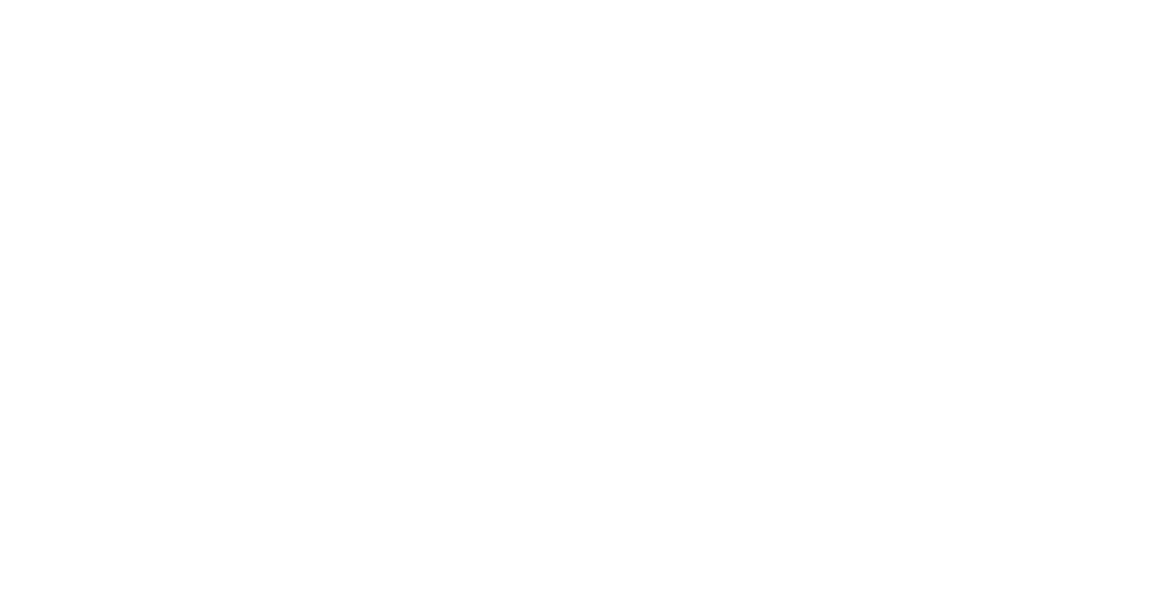

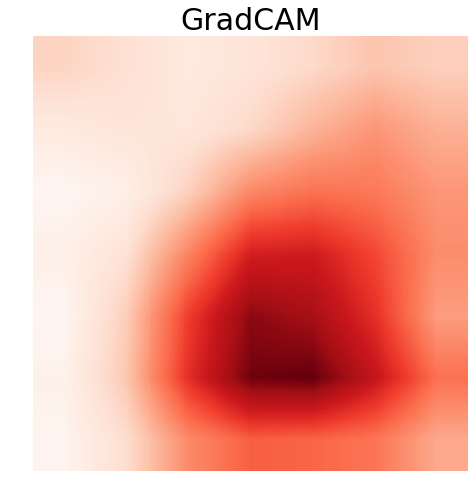

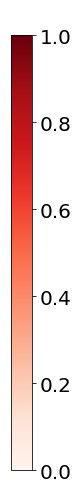

In [57]:
for idx, question_path in enumerate([Q1_path, Q2_path, Q3_path, Q4_path, Q5_path, Q6_path]):
    representatives = glob.glob(question_path + '/*.*')
#     Tracer()()
    if idx != 1:
        continue
    for representative in representatives:
        if '21805' not in representative:
            continue
        sample_idx = representative.split('aggregate/')[1]
        image_path = os.path.join(Q_datapath[idx], sample_idx)
#         image_path = os.path.join('/home/dexter/Downloads/val', sample_folder, sample_idx)
#         if '6952' not in image_path:
#             continue
        distance_dict = dict()
        neighbors = list()
        categories_confidences = list()
        confidences= list ()

        img = Image.open(image_path)

        if NN_flag:
            embedding = feature_extractor(transform(img).unsqueeze(0).to(device)).flatten(start_dim=1) 

        input_image = img.resize((size,size), Image.ANTIALIAS)

        # Get the ground truth of the input image
        gt_label_id = image_path.split('val_')[1][9:18]


        gt_label = id_map.get(gt_label_id)
        id = key_list.index(gt_label_id)
        gt_label = gt_label.split(',')[0]

        # Get the prediction for the input image
        img = Image.open(image_path)
        x = transform(img).unsqueeze(0).to(device)
        out = model(x)
        p = torch.nn.functional.softmax(out, dim=1)
        score, index = torch.topk(p, 1)
        input_category_id = index[0][0].item()
        predicted_confidence = score[0][0].item()
        predicted_confidence = ("%.2f") %(predicted_confidence)


        input_prediction_id = convert_imagenet_label_to_id(label_map, key_list, val_list, input_category_id)
        predicted_label = id_map.get(input_prediction_id).split(',')[0]
        predicted_label = predicted_label[0].lower() + predicted_label[1:]

        print(predicted_label)
        print(predicted_confidence)

        # Original image
        
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        
        fig = plt.figure()
#         plt.figure(figsize=(6.0,4.5), dpi=300)
        plt.axis('off')
        #predicted_label = 'african hunting dog'
        plt.title('{}: {}'.format(predicted_label, predicted_confidence), fontsize=30)
        plt.imshow(input_image)
        plt.savefig('tmp/original.jpeg', figsize=(6.0,4.5), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()
        cmd = 'convert tmp/original.jpeg -resize 630x600\! tmp/original.jpeg'
        os.system(cmd)


        # Edge image
        img = cv.resize(cv.imread(image_path,0),((size,size)))
        edges = cv.Canny(img,100,200)
        edges = edges - 255

        fig = plt.figure()
        
#         plt.figure(figsize=(6.0,4.5), dpi=300)
        plt.axis('off')
        plt.title(' ', fontsize=60)
        plt.imshow(edges, cmap = 'gray')
        plt.savefig('tmp/Edge.jpeg', figsize=(6.0,4.5), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

        # GradCAM
        saliency = grad_cam(
            model, x, input_category_id,
            saliency_layer='layer4',
            resize=True
        )

        saliency *= 1.0/saliency.max()
        GradCAM = saliency[0][0].cpu().detach().numpy()

        fig = plt.figure()
        
#         plt.figure(figsize=(6.0,4.5), dpi=300)
        plt.axis('off')
        plt.title('GradCAM', fontsize=30)
        mlb = plt.imshow(GradCAM, cmap=cMap, vmin=0, vmax=1)
        # plt.colorbar(orientation='vertical')
        plt.savefig('tmp/heatmap.jpeg', figsize=(6.0,4.5), dpi=300, bbox_inches='tight', pad_inches=0)
#         plt.close()

        myCmd = 'composite -blend 10 tmp/Edge.jpeg -gravity SouthWest tmp/heatmap.jpeg tmp/GradCAM.jpeg'
        os.system(myCmd)
        cmd = 'convert tmp/GradCAM.jpeg -resize 600x600\! tmp/GradCAM.jpeg'
        os.system(cmd)
        
        # draw a new figure and replot the colorbar there
        fig,ax = plt.subplots()
        cbar = plt.colorbar(mlb,ax=ax)
        cbar.ax.tick_params(labelsize=20)
        ax.remove()
        # save the same figure with some approximate autocropping
        
        plt.title(' ', fontsize=30)
        plt.savefig('tmp/color_bar.jpeg', dpi=300, bbox_inches='tight')
        cmd = 'convert tmp/color_bar.jpeg -resize 100x600\! tmp/color_bar.jpeg'
        os.system(cmd)
        
        # Extremal Perturbation
        saliency = get_EP_saliency_maps(model, image_path)
        ep_saliency_map = tensor2img(saliency)
        ep_saliency_map *= 1.0/ep_saliency_map.max()

        fig = plt.figure()
#         plt.figure(figsize=(6.0,4.5), dpi=300)
        plt.axis('off')
        plt.title('EP', fontsize=30)
        plt.imshow(ep_saliency_map, cmap=cMap, vmin=0, vmax=1)
#         plt.colorbar(orientation='vertical')
        plt.savefig('tmp/heatmap.jpeg', figsize=(6.0,4.5), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

        # Get overlay version
        myCmd = 'composite -blend 10 tmp/Edge.jpeg -gravity SouthWest tmp/heatmap.jpeg tmp/EP.jpeg'
        os.system(myCmd)
        cmd = 'convert tmp/EP.jpeg -resize 600x600\! tmp/EP.jpeg'
        os.system(cmd)

        # Salient Object Detection    
        from shutil import copyfile, rmtree
        def rm_and_mkdir(path):
            if os.path.isdir(path) == True:
                rmtree(path)
            os.mkdir(path)

        # Prepare dataset
        rm_and_mkdir('/home/dexter/Downloads/run-0/run-0-sal-p/')
        rm_and_mkdir('/home/dexter/Downloads/PoolNet-master/data/PASCALS/Imgs/')
        if os.path.isdir('/home/dexter/Downloads/PoolNet-master/data/PASCALS/test.lst'):
            os.remove('/home/dexter/Downloads/PoolNet-master/data/PASCALS/test.lst')

        src_paths = [image_path]
        for src_path in src_paths:
            dst_path = '/home/dexter/Downloads/PoolNet-master/data/PASCALS/Imgs/' + src_path.split('images/')[1]
            copyfile(src_path, dst_path)

        cmd = 'ls /home/dexter/Downloads/PoolNet-master/data/PASCALS/Imgs/ > /home/dexter/Downloads/PoolNet-master/data/PASCALS/test.lst'
        os.system(cmd)
        cmd = 'python /home/dexter/Downloads/PoolNet-master/main.py --mode=\'test\' --model=\'/home/dexter/Downloads/run-0/run-0/models/final.pth\' --test_fold=\'/home/dexter/Downloads/run-0/run-0-sal-p/\' --sal_mode=\'p\''
        os.system(cmd)


        npy_file_paths = glob.glob('/home/dexter/Downloads/run-0/run-0-sal-p/*.*')
        npy_file = np.load(npy_file_paths[0])
        fig = plt.figure()
#         plt.figure(figsize=(6.0,4.5), dpi=300)
        plt.axis('off')
        plt.title('SOD', fontsize=30)
        plt.imshow(npy_file, cmap=cMap, vmin=0, vmax=1)
        # plt.colorbar(orientation='vertical')
        plt.savefig('tmp/heatmap.jpeg', figsize=(6.0,4.5), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()

        # Get overlay version
        myCmd = 'composite -blend 10 tmp/Edge.jpeg -gravity SouthWest tmp/heatmap.jpeg tmp/SOD.jpeg'
        os.system(myCmd)
        cmd = 'convert tmp/SOD.jpeg -resize 600x600\! tmp/SOD.jpeg'
        os.system(cmd)

        # Nearest Neighbors
        imagenet_train_path = '/home/dexter/Downloads/train'
        if NN_flag:
            from utils import *
            ## Nearest Neighbors

            predicted_set_path = os.path.join(imagenet_train_path, input_prediction_id)
            predicted_set_img_paths = glob.glob(predicted_set_path + '/*.*')
            predicted_set_color_images= list()

            embedding = embedding.detach()
            embedding.to(device)
            # Build search space for nearest neighbors
            for i, path in enumerate(predicted_set_img_paths):
                img = Image.open(path)
                if img.mode != 'RGB':
                    img.close()
                    del img
                    continue

                x = transform(img).unsqueeze(0).to(device)
                out = model(x)
                p = torch.nn.functional.softmax(out, dim=1)
                del out
                score, index = torch.topk(p, 1)
                del p
                category_id = index[0][0].item()
                del score, index

    #             This is to avoid the confusion from crane 134 and crane 517 and to make NNs work :)
    #             Because in Imagenet, annotators mislabeled 134 and 517

                if input_category_id != 134 and input_category_id != 517 and category_id != 134 and category_id != 517:
                    if input_category_id != category_id:
                        continue

                f = feature_extractor(x)
                feature_vector = f.flatten(start_dim=1).to(device)
                feature_vector = feature_vector.detach()

                del f
                distance_dict[path] = torch.dist(embedding, feature_vector)

                del feature_vector 
                torch.cuda.empty_cache()
                img.close()
                del img
                predicted_set_color_images.append(path)

            # Get K most similar images
            res = dict(sorted(distance_dict.items(), key = itemgetter(1))[:K]) 
            print("Before...")
            print(res)
    #         Tracer()()
            while distance_dict[list(res.keys())[0]] < 100:
                del distance_dict[list(res.keys())[0]]
                res = dict(sorted(distance_dict.items(), key = itemgetter(1))[:K]) 
            print("After...")
            print(res)
    #         del distance_dict
            del embedding

            similar_images = list(res.keys())

            for similar_image in similar_images:
                img = Image.open(similar_image)
                neighbors.append(img.resize((size,size), Image.ANTIALIAS))
                x = transform(img).unsqueeze(0).to(device)
                out = model(x)
                p = torch.nn.functional.softmax(out, dim=1)
                score, index = torch.topk(p, 1) # Get 1 most probable classes
                category_id = index[0][0].item()
                confidence = score[0][0].item()

                label = label_map.get(category_id).split(',')[0].replace("\"", "")
                label = label[0].lower() + label[1:]
                print(label + ": %.2f" %(confidence))

                categories_confidences.append((label + ": %.2f" %(confidence)))
                confidences.append(confidence)
                img.close()

            for index, neighbor in enumerate(neighbors):
                fig = plt.figure()
#                 plt.figure(figsize=(6.0,4.5), dpi=300)
                plt.axis('off')
                if index == 1: # Make title for the middle image (2nd image) to annotate the 3 NNs
                    plt.title('3-NN'.format(predicted_label), fontsize=30)
                else:
                    plt.title(' ', fontsize=30)
                plt.imshow(neighbor)
                plt.savefig('tmp/{}.jpeg'.format(index), figsize=(6.0,4.5), dpi=300, bbox_inches='tight', pad_inches=0)
                plt.close()
                cmd = 'convert tmp/{}.jpeg -resize 600x600\! tmp/{}.jpeg'.format(index, index)
                os.system(cmd)


            myCmd = 'montage tmp/[0-2].jpeg -tile 3x1 -geometry +0+0 tmp/NN.jpeg'
            os.system(myCmd)

        # Sample images and definition
        print(image_path)
        gt_label = image_path.split('images/')[1][34:43]
        print(image_path)
        print(gt_label)
        sample_path = '/home/dexter/Downloads/A-journey-into-Convolutional-Neural-Network-visualization-/sample_images'
        predicted_sample_path = os.path.join(sample_path, gt_label + '.jpeg')
        textual_label = id_map.get(gt_label).split(',')[0]
        textual_label = textual_label[0].lower() + textual_label[1:]
        definition = '{}: {}'.format(textual_label, definition_dict[gt_label])
        definition = definition.replace("'s", "")
        print(definition)
        
#         definition = 'any sluggish bottom-dwelling ray of the order Torpediniformes having a rounded body and electric organs on each side of the head capable of emitting strong electric discharges'

        # Responsive annotation of imagemagick (only caption has responsive functions)
        cmd = 'convert {} -resize 2400x600\! tmp/sample_def.jpeg'.format(predicted_sample_path)
        os.system(cmd)
        cmd = 'convert tmp/sample_def.jpeg -background White  -size 2395x \
        -pointsize 50 -gravity Center \
        caption:\'{}\' \
        +swap -gravity Center -append tmp/sample_def.jpeg'.format(definition)
        os.system(cmd)

        # Top-k predictions
        img = Image.open(image_path)
        x = transform(img).unsqueeze(0).to(device)
        out = model(x)
        p = torch.nn.functional.softmax(out, dim=1)
        score, index = torch.topk(p, 5)
    #     Tracer()()

        predicted_labels = []
        predicted_confidences = []
        colors = []

        for i in range(5):
            input_prediction_id = convert_imagenet_label_to_id(label_map, key_list, val_list, index[0][i].item())
            if input_prediction_id == gt_label:
                colors.append('lightcoral')
            else:
                colors.append('mediumslateblue')
            predicted_label = id_map.get(input_prediction_id).split(',')[0]
            predicted_label = predicted_label[0].lower() + predicted_label[1:]
            predicted_labels.append(predicted_label)
            predicted_confidences.append(score[0][i].item())

    #     plt.rcdefaults()
        fig, ax = plt.subplots()

        y_pos = np.arange(len(predicted_labels))
        ax.tick_params(axis='y', direction='in',pad=-100)
        ax.tick_params(axis = "x", which = "both", bottom = False, top = False) # turn off xtick
        ax.barh(predicted_labels, predicted_confidences, align='center', color=colors, height=1.0)

        ax.set_xlim(0,1)
        ax.set_yticklabels(predicted_labels, horizontalalignment = "left", fontsize=64, weight='bold')
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_title(textual_label, fontsize=60, weight='bold') #1

        # remove the x and y ticks
        ax.set_xticks([])

        plt.savefig('tmp/top5.jpeg', figsize=(6.0,4.5), dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close()
        #cmd = 'convert tmp/top5.jpeg -resize 570x400\! tmp/top5.jpeg'
        cmd = 'convert tmp/top5.jpeg -resize 580x400\! tmp/top5.jpeg'
        os.system(cmd)
        cmd = 'convert tmp/top5.jpeg -gravity North -background white -extent 100x150% tmp/top5.jpeg'
        os.system(cmd)

#         cmd = 'montage original.jpeg GradCAM.jpeg EP.jpeg SOD.jpeg color_bar.jpeg -tile 5x1 -geometry 600x600+0+0 agg1.jpeg'
        cmd = 'convert tmp/original.jpeg tmp/GradCAM.jpeg tmp/EP.jpeg tmp/SOD.jpeg tmp/color_bar.jpeg -gravity center +append tmp/agg1.jpeg'
        os.system(cmd)
    #     cmd = 'montage top5.jpeg NN.jpeg -tile 2x1 -geometry +0+0 agg2.jpeg'
#         cmd = 'montage top5.jpeg [0-2].jpeg -tile 4x1 -geometry 600x600+0+0 agg2.jpeg'
        cmd = 'convert tmp/top5.jpeg tmp/[0-2].jpeg -gravity center +append tmp/agg2.jpeg'
        os.system(cmd)
        cmd = 'convert tmp/agg2.jpeg -gravity West -background white -extent 101.5x100% tmp/agg2.jpeg'
        os.system(cmd)

        cmd = 'convert tmp/agg1.jpeg tmp/agg2.jpeg tmp/sample_def.jpeg -gravity center -append {}'.format(representative)
        print(cmd)
        os.system(cmd)
